In [1]:
# Libraries
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from IPython.core.interactiveshell import InteractiveShell

# Notebook Settings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("error")
pd.set_option('display.max_columns', 500)
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

### 1. Read data
We requested historical wheat yield data from the [Brazilian Institute of Geography and Statistics](https://sidra.ibge.gov.br/tabela/1612) from the three southern states of Brazil: Rio Grande do Sul, Paraná, and Santa Catarina. These states are responsible for roughly [90%](https://sidra.ibge.gov.br/tabela/1612) of Brazilian wheat production. 

Whenever we use the term **national wheat yield** from now on, we actually refer to the wheat yield in the three southern states. Having said that, we will now read the file with the national wheat yield from 1993 to 2016. We chose that period so that the crop data matches the time period of the available seasonal climate forecasts.

0.05233695652173764


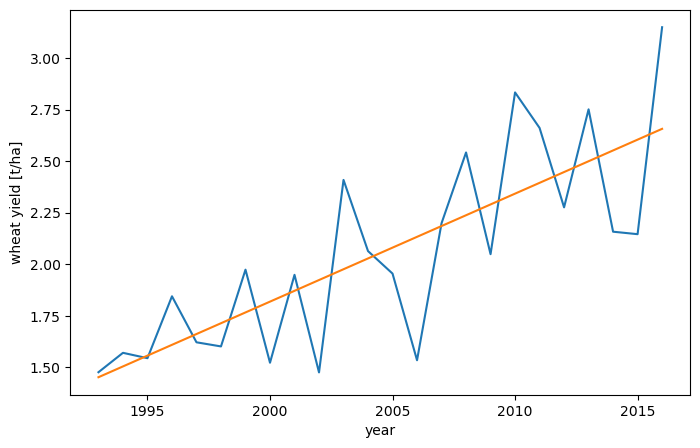

In [2]:
national_yield = pd.read_excel("Data/Wheat/ibge_wheat_yield_south.xlsx", dtype=float).transpose().reset_index().rename(columns={"index":"year", 0:"yield"}).apply(pd.to_numeric)
national_yield["yield"] = national_yield["yield"] / 1000
ax = national_yield.plot("year", "yield", legend=False, figsize=(8,5));
m, b = np.polyfit(national_yield["year"], national_yield["yield"], 1);
print(m)
plt.plot(national_yield["year"], m*national_yield["year"] + b);
ax.set_ylabel("wheat yield [t/ha]");
ax.set_xlabel("year");
#plt.savefig("images/national_wheat_yield.svg")

Our model will be used to explain climate-induced wheat yield variabilities. Long term trends (orange line) that arise through cultivar improvement or optimized crop management will not be the focus of this study. Therefore, we need to detrend the data.

### 2. Detrend Wheat Yield Data

We chose to lift historical yield observations to the current level of technology, which is indicated by the wheat yield in 2016. We assume a linear growth of yield from 1993 to 2016. To trend-correct the yield for a given year, we estimate a slope using the yield of all other years. This slope indicates the average growth of yield from one year to another based on technological progress. We trend-correct all years from 1993 to 2016. 

$yield\_ corrected_n = yield_n + (slope * (2016 - year_n))$

In [3]:
def detrend_national_yield(df):
    df = df.copy()
    li=[]
    print(df.columns)
    for year in list(range(1993,2017)):
        yields_to_calculate_trend = df.loc[df["year"] != year].copy().reset_index(drop=True)
        yield_to_be_adjusted = df.loc[df["year"] == year].copy().reset_index(drop=True)
        reg = LinearRegression()
        slope_cv = reg.fit(yields_to_calculate_trend["year"].values.reshape(-1,1), yields_to_calculate_trend["yield"]).coef_[0]

        yield_to_be_adjusted["yield_detrended"] = yield_to_be_adjusted["yield"] + (slope_cv * (2016 - yield_to_be_adjusted["year"].astype(int)))
        li.append(yield_to_be_adjusted)
        
    df_cv = (pd
             .concat(li, axis=0, ignore_index=False)
             .reset_index(drop=True)
             .drop(["yield"], axis=1)
             .rename(columns={"yield_detrended":"yield"})
             .apply(pd.to_numeric))
    
    return df_cv

Index(['year', 'yield'], dtype='object')


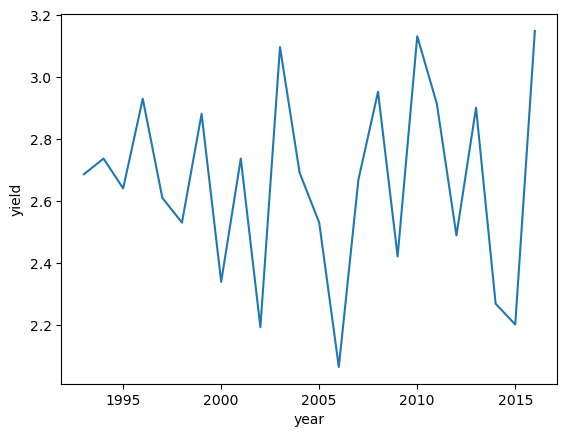

In [4]:
national_yield_detrended = detrend_national_yield(national_yield)
sns.lineplot(data=national_yield_detrended, x="year", y="yield");
#plt.savefig("images/detrended_national_wheat_yield.svg")

In [5]:
#national_yield_detrended.to_csv("Data/Wheat/ibge_national_yield_detrended.csv", index=False)

### 3. Yield by Group

In [6]:
columns = ['code', 'zone', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
yield_by_municipality = pd.read_csv("data/wheat/yield_by_year_and_municipality.csv", usecols=columns) # 1993-2019
harvested_area_by_municipality = pd.read_csv("data/wheat/harvested_area_by_year_and_municipality.csv", usecols=columns) # 1990-2019

#### Calculate wheat yield by group

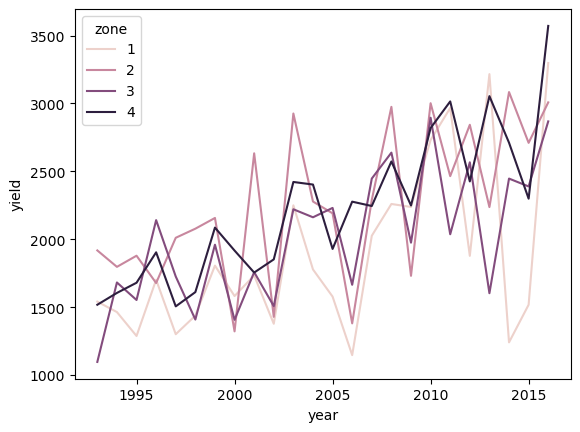

In [7]:
yield_by_group = ((yield_by_municipality.set_index(["code", "zone"]) 
                  * harvested_area_by_municipality.set_index(["code", "zone"]))
                  .groupby(["zone"])
                  .sum()) / (harvested_area_by_municipality
                             .set_index(["code", "zone"])
                             .groupby(["zone"])
                             .sum())
yield_by_group = yield_by_group.stack().reset_index().rename({"level_1":"year", 0:"yield"}, axis=1)
yield_by_group = (np.round(yield_by_group.loc[yield_by_group["year"].astype(int).isin(list(range(1993,2018)))]
                           .reset_index(drop=True), 2))

sns.lineplot(data=yield_by_group.astype(int), x="year", y="yield", hue="zone");

In [8]:
for group in list(range(1,5)):
    m, b = np.polyfit(yield_by_group.loc[yield_by_group["zone"] == group, "year"].astype(np.float64), yield_by_group.loc[yield_by_group["zone"] == group, "yield"].astype(np.float64), 1)
    yield_by_group.loc[yield_by_group["zone"] == group, "linear"] = m*yield_by_group.loc[yield_by_group["zone"] == group, "year"].astype(np.float64) + b

In [9]:
yield_by_group["yield"] = yield_by_group["yield"].apply(lambda x: np.round(x/1000, 2))
yield_by_group["linear"] = yield_by_group["linear"].apply(lambda x: np.round(x/1000, 2))


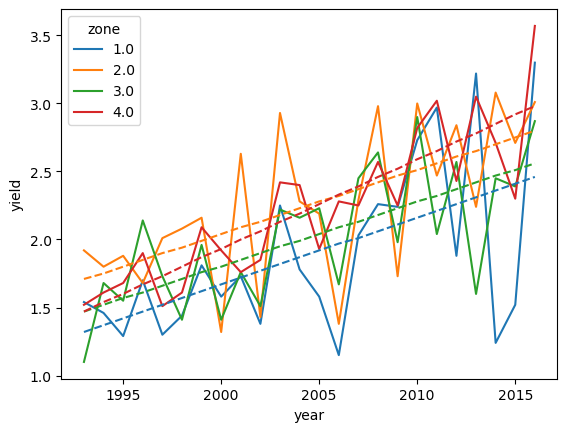

In [11]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=yield_by_group.astype(float), x="year", y="yield", hue="zone", linestyle="-", palette="tab10", legend=False);
sns.lineplot(data=yield_by_group.astype(float), x="year", y="linear", hue="zone", linestyle="--", palette="tab10");
#plt.savefig("group_plot.svg")
plt.show();

#### Detrend Group yield

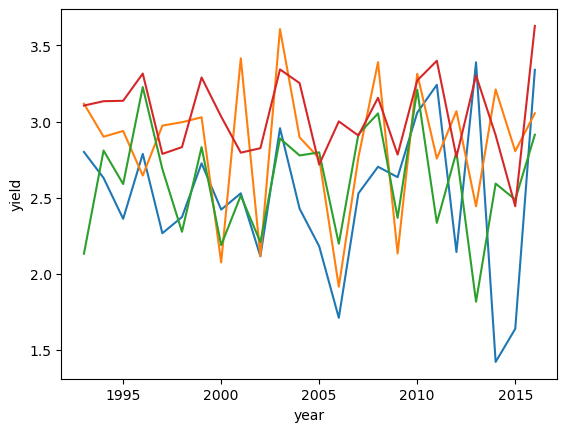

In [12]:
def detrend_yield_by_group(df):
    df = df.copy()
    li = []
    for group in [1, 2, 3, 4]:
        for year in list(range(1993,2017)):
            group_yield = df.loc[(df["zone"] == group)].copy().reset_index(drop=True)
            yields_to_calculate_trend = group_yield.loc[group_yield["year"].astype(int) != year].copy().reset_index(drop=True)
            yield_to_be_adjusted = group_yield.loc[group_yield["year"].astype(int) == year].copy().reset_index(drop=True)
            reg = LinearRegression()
            slope_cv = reg.fit(yields_to_calculate_trend["year"].values.reshape(-1,1), yields_to_calculate_trend["yield"]).coef_[0]
            yield_to_be_adjusted["yield_detrended"] = yield_to_be_adjusted["yield"] + (slope_cv * (2017 - yield_to_be_adjusted["year"].astype(int)))
            li.append(yield_to_be_adjusted)

    df_cv = (pd
             .concat(li, axis=0, ignore_index=False)
             .sort_values(by=["zone", "year"])
             .reset_index(drop=True)
             .drop(["yield"], axis=1)
             .rename(columns={"yield_detrended":"yield"}))
        
    return df_cv

yield_by_group_detrended = detrend_yield_by_group(yield_by_group)
sns.lineplot(data=yield_by_group_detrended.loc[yield_by_group_detrended["year"].astype(int) > 1992].astype(float), x="year", y="yield", hue="zone", palette="tab10", legend=False);
#plt.savefig("detrended_yield_by_group.svg")

In [108]:

#yield_by_group_detrended.to_csv("data/wheat/yield_by_group_detrended.csv", index=False)